## To add in:

* explanation of induced graph
* removal of isolates - why
* parititions found are not perfect - many more person hours!

# Jean Golding Institute: PURE Data Challenge 2017
### Entry by: Chris McWilliams, EngMaths 


This slideshow contains my entry to the PURE Data Challenge - in it I develop a proof-of-concept for a novel approach to the study of interdisciplinarity. The approach draws inspiration from the field of *network ecology*.

The slideshow is rendered using *reveal.js* and *jupyter notebook*. It is organised in a series of columns. Please navigate to the bottom of a column (using down-arrow), before proceeding to the next column (using right-arrow). 

The complete python code used to generate the results can be viewed in-line using the button below, but the formatting is best with code view turned off. Press F11 to view in fullscreen.

## Contents:

### A. The collaboration network
### B. The publication network
### C. The mutualistic network

In [127]:
import networkx as nx
import os
import itertools
import pickle
import matplotlib.pyplot as plt
import graphlab
from graphlab import aggregate as agg
import numpy as np
from datetime import datetime
import community
from collections import OrderedDict
from IPython.display import Image, display
import sklearn.metrics as sklm
%matplotlib inline

## A. The collaboration network

A natural way to represent the PURE data is as a *collaboration network* between authors. Each *node* in this network represents an author, and they are connected by a *link* if they have co-authored a paper. Link *weights* are given by the number of papers co-authored by that pair of authors. 

We construct this network using the package *networkx*. With each author plotted on the edge of a cirlce, the whole collaboration network looks like this:

In [142]:
authors = graphlab.SFrame.read_csv('170331_PURE_Data_Challenge/PURE Data Challenge/authors.csv', delimiter=',', skiprows=0, na_values=['NA','NULL'], verbose=False)
pub_authors = authors.groupby(key_columns='PUBLICATION_ID', operations={'authors':agg.CONCAT('PERSON_ID')})
#pub_authors.print_rows(num_rows=5)

In [49]:
def create_collab_net(links):
    '''Take dictionary of links and produce networkx graph.'''
    
    nodes = []
    for l in links.keys():
        if l[0] not in nodes:
            nodes.append(l[0])
        if l[1] not in nodes:
            nodes.append(l[1])
            
    G = nx.Graph()
    G.add_nodes_from(nodes)
    for l in links.keys():
        G.add_edge(*l, weight=links[l])
        
    return G

In [411]:
solo_count = 0
links = dict()
for pub in pub_authors:
    
    if len(pub['authors'])==1:
        solo_count += 1
    else:
        _links = itertools.combinations(pub['authors'],2)
        for l in _links:
            if l not in links.keys():
                links[l] = 1
            else:
                links[l] +=1
                
G = create_collab_net(links)

#print "Network created:"
print "(There are %d nodes (authors) in this network, and %d links.)" %(len(G.nodes()),len(G.edges()))

(There are 2561 nodes (authors) in this network, and 9268 links.)


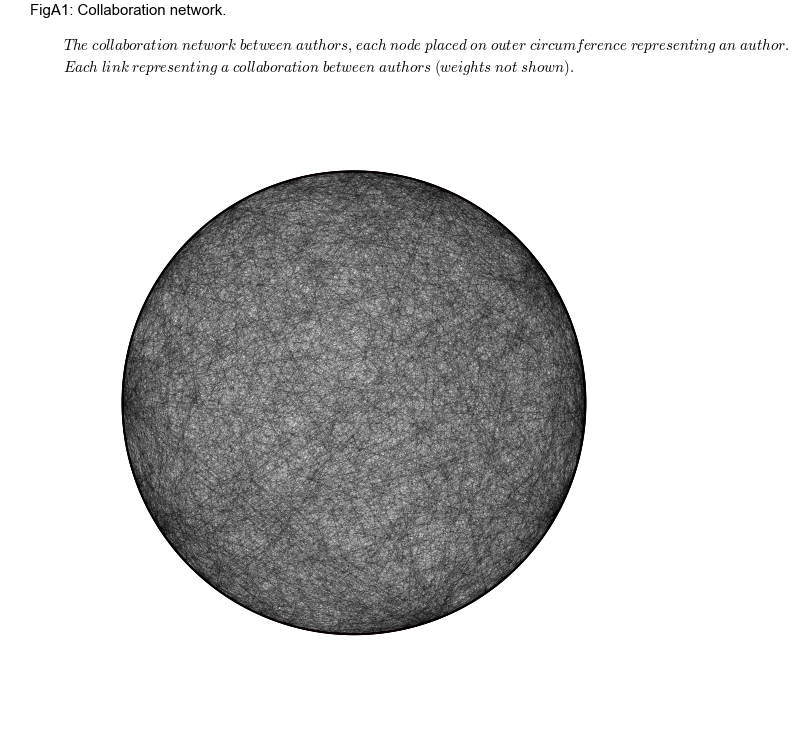

In [346]:
plt.figure(figsize=(9,9))
plt.subplots_adjust(top=1.1)
nx.draw_circular(G, node_size=1, width=0.05)

tfs=15
subtitle = 'The collaboration network between authors, each node placed on outer circumference representing an author.'.replace(' ','\ ')
subtitle_l2 = 'Each link representing a collaboration between authors (weights not shown).'.replace(' ','\ ')
title = plt.title('FigA1: Collaboration network. \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')


Beyond an appreciation of the complexity of the collaborations ongoing at the University, there is not much to be learned from the previous network image.

We can simplify the representation by aggregating authors into groups. A natural node grouping, or *partition* of the network, is given by the *organisation* to which each author belongs. 

Grouping authors into organisations, the network looks like this: 

In [53]:
## We load the staff data, and assign an integer id (orgid) to each ORGANISATION_CODE that is in use.
## There is some duplication in the staff table, so we filter duplicate entries.
staff = graphlab.SFrame.read_csv('170331_PURE_Data_Challenge/PURE Data Challenge/staff.csv', delimiter=',', skiprows=0, na_values=['NA','NULL'], verbose=False)
orgs = staff['ORGANISATION_CODE'].unique()
orgdict = dict()
for ii,org in enumerate(orgs):
    orgdict[org] = ii
    
staff['orgid'] = staff['ORGANISATION_CODE'].apply(lambda org: orgdict[org])
staff = staff.groupby(key_columns='PERSON_ID', operations={
                                            'ORGANISATION_CODE':agg.SELECT_ONE('ORGANISATION_CODE'),
                                            'TYPE':agg.SELECT_ONE('TYPE'),
                                            'orgid':agg.SELECT_ONE('orgid'),
                                        })

In [54]:
def _calc_group_sizes(part):
    '''Calculates groups sizes for a given partition (dict)'''
    community_sizes = OrderedDict.fromkeys(np.unique(part.values()),0)
    for node in part.keys():
        community_sizes[part[node]] += 1
        
    return community_sizes

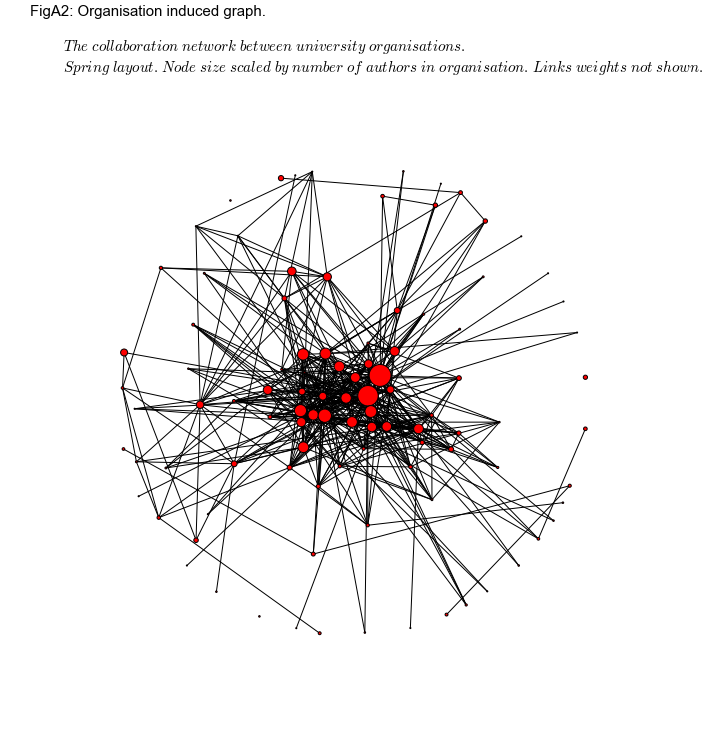

In [349]:
node_scaling = 1.2
partition_pure = dict(zip(staff['PERSON_ID'], staff['orgid']))
IG = community.induced_graph(graph=G, partition=partition_pure)
organisation_sizes = _calc_group_sizes(partition_pure)

plt.figure(figsize=(9,9))
pos = nx.spring_layout(IG,k=0.2)
nx.draw(IG, pos=pos, nodelist=[node for node in IG.nodes()], node_size=[node_scaling * organisation_sizes[node] for node in IG.nodes()])

tfs=15
subtitle = 'The collaboration network between university organisations.'.replace(' ','\ ')
subtitle_l2 = 'Spring layout. Node size scaled by number of authors in organisation. Links weights not shown.'.replace(' ','\ ')
title = plt.title('FigA2: Organisation induced graph. \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')

In the above plot organisations are red circles - their size scaled by the number of authors they contain.

The network layout is generated using a spring algorithm, such that strongly interacting organisations are bunched together.

We notice a core of larger organisations that collaborate strongly with others, surrounded by a periphery of smaller and more insular (specialised) organisations. Three small organisations have only internal collaborations.

#### It is clear that there is a significant amount of research that crosses organisational boundaries.

In fact the organisational strucutre of the university is a hierarchical tree that looks like this:

In [59]:
hierarchy = graphlab.SFrame.read_csv('170331_PURE_Data_Challenge/PURE Data Challenge/org_hierarchy.csv', delimiter=',', skiprows=0, na_values=['NA','NULL'], verbose=False)
orgkey = graphlab.SFrame.read_csv('170331_PURE_Data_Challenge/PURE Data Challenge/org_key.csv', delimiter=',', skiprows=0, na_values=['NA','NULL'], verbose=False)

In [60]:
H = nx.DiGraph()

added =[]
for row in hierarchy:
    n1 = row['PARENT_ORG_CODE']
    n2 = row['CHILD_ORG_CODE']
    
    if n1 not in added:
        H.add_node(n1)
        added.append(n1)
    if n2 not in added:
        H.add_node(n2)
        added.append(n2)
        
for row in hierarchy:
    n1 = row['PARENT_ORG_CODE']
    n2 = row['CHILD_ORG_CODE']
    H.add_edge(n1,n2)

In [61]:
## Credit to: stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3
def hierarchy_pos(G, root, width=5., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = G.neighbors(root)
    if parent != None and parent in neighbors:
        #print parent
        #print neighbors
        neighbors.remove(parent)
    if len(neighbors)!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos

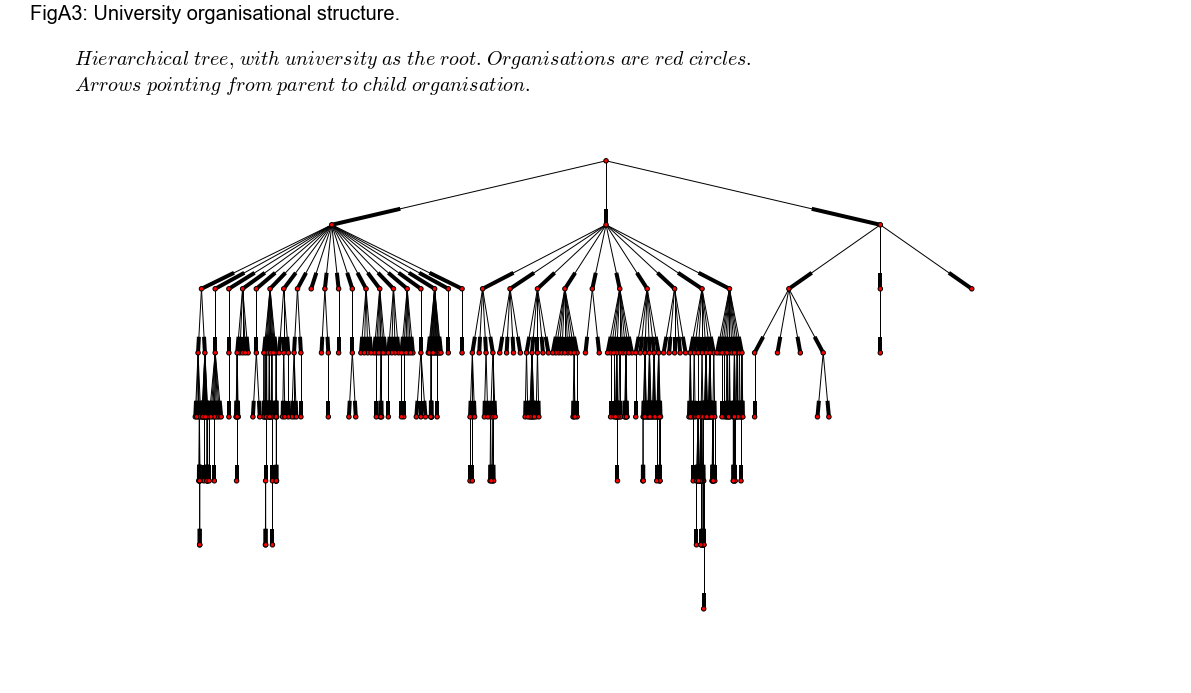

In [381]:
pos = hierarchy_pos(H,'UNIV')    
plt.figure(figsize=(16,8))
nx.draw(H, pos=pos, with_labels=False, node_size=20)

tfs=20
subtitle = 'Hierarchical tree, with university as the root. Organisations are red circles.'.replace(' ','\ ')
subtitle_l2 = 'Arrows pointing from parent to child organisation.'.replace(' ','\ ')
title = plt.title('FigA3: University organisational structure. \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')

The root of the tree is the whole University, and child organisations are nested below. Organisation membership of individuals is given in *'staff.csv'*, sometimes at different levels of this hierarchy. If we were to aggregate our collaboration network to organisations at some higher level of the tree, we would lose some of the smaller organisations and, perhaps, some of the apparent interdisciplinarity. However, for simplicity we take organisation membership at the level given in *'staff.csv'*.

#### But why should the traditional organisational structure be the one that best represents current collaborations?

#### Can we find a better one?

#### We seek a different grouping of authors into communities that more closely resemble their research collaborations..

To do this we use *community detection* - identifying groups of authors that collaborate more within their group than without. We use the Louvain algorithm [1], which optimises a qunatity called *modularity*. The groups it identifies are called communities, and the network produced by aggregating nodes into these communities is referred to as the *induced graph*.
 
The algorithm gives sequential levels of community structure - with fewer communities of increasing size at each level. The final level is the *best* community structure achieved by the algorithm.

For our collaboration network the algorithm produces three levels of community structure. The first level contains 407 communities, and the induced graph looks like this:


(With communities plotted on concentric circles, with isolates in the outer ring. The plotted community sizes are scaled by number of authors.)

In [63]:
den = community.generate_dendrogram(G)
part0 = den[0]

part1=dict()
for key in part0.keys():
    part1[key] = den[1][part0[key]]

part2=dict()
for key in part0.keys():
    part2[key] = den[2][part1[key]]

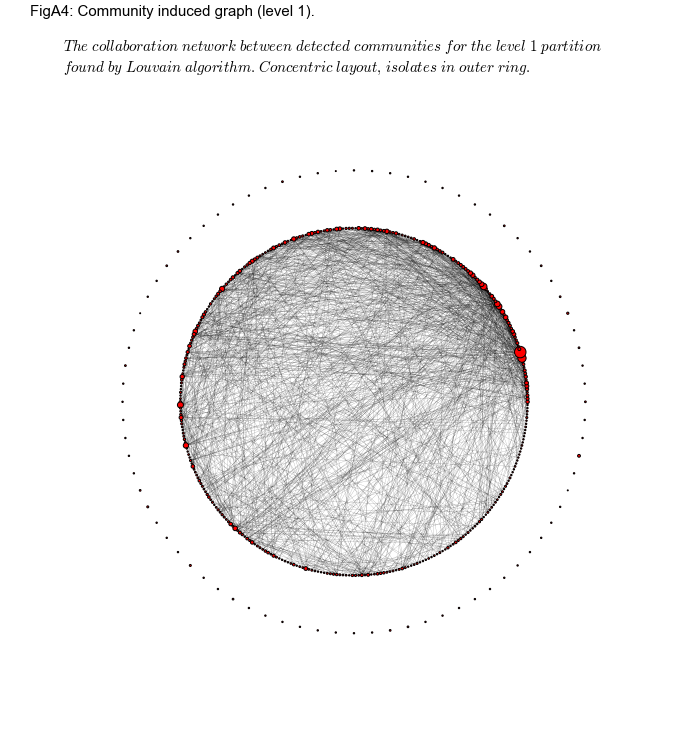

In [352]:
IG = community.induced_graph(graph=G, partition=part0)
community_sizes = _calc_group_sizes(part0)

plt.figure(figsize=(9,9))
test_nodes = IG.nodes()
isolates  = []
for node in test_nodes:
    node_in_edges = False
    for ed in IG.edges():
        if node in ed and ed[0]!=ed[1]:
            node_in_edges = True
            break
    
    if not node_in_edges:
        isolates.append(node)

connected = [node for node in IG.nodes() if node not in isolates]        
_sub0 = IG.subgraph(nbunch=isolates)
_sub1 = IG.subgraph(nbunch=connected)

nx.draw_circular(_sub0, nodelist=_sub0.nodes(), node_size=[community_sizes[n] for n in _sub0.nodes()])
pos = nx.circular_layout(_sub1)
for p in pos.keys():
    pos[p][0] = pos[p][0]*0.75 + 0.125
    pos[p][1] = pos[p][1]*0.75 + 0.125
    
nx.draw(_sub1, pos=pos, nodelist=_sub1.nodes(), node_size=[community_sizes[n] for n in _sub1.nodes()], width=0.1)

tfs=15
subtitle = 'The collaboration network between detected communities for the level 1 partition'.replace(' ','\ ')
subtitle_l2 = 'found by Louvain algorithm. Concentric layout, isolates in outer ring.'.replace(' ','\ ')
title = plt.title('FigA4: Community induced graph (level 1). \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')

The second level contains 129 communities and looks like this:

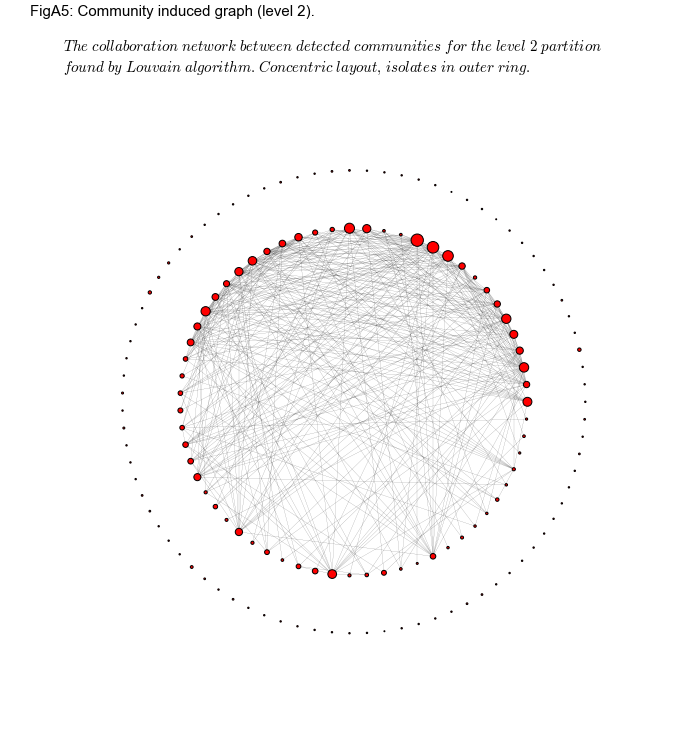

In [355]:
IG = community.induced_graph(graph=G, partition=part1)
community_sizes = _calc_group_sizes(part1)

plt.figure(figsize=(9,9))
test_nodes = IG.nodes()
isolates  = []
for node in test_nodes:
    node_in_edges = False
    for ed in IG.edges():
        if node in ed and ed[0]!=ed[1]:
            node_in_edges = True
            break
    
    if not node_in_edges:
        isolates.append(node)

connected = [node for node in IG.nodes() if node not in isolates]        
_sub0 = IG.subgraph(nbunch=isolates)
_sub1 = IG.subgraph(nbunch=connected)

nx.draw_circular(_sub0, nodelist=_sub0.nodes(), node_size=[community_sizes[n] for n in _sub0.nodes()])
pos = nx.circular_layout(_sub1)
for p in pos.keys():
    pos[p][0] = pos[p][0]*0.75 + 0.125
    pos[p][1] = pos[p][1]*0.75 + 0.125
    
nx.draw(_sub1, pos=pos, nodelist=_sub1.nodes(), node_size=[community_sizes[n] for n in _sub1.nodes()], width=0.1)

tfs=15
subtitle = 'The collaboration network between detected communities for the level 2 partition'.replace(' ','\ ')
subtitle_l2 = 'found by Louvain algorithm. Concentric layout, isolates in outer ring.'.replace(' ','\ ')
title = plt.title('FigA5: Community induced graph (level 2). \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')

And the best partition, given by the third level, contains 110 communities and looks like this:

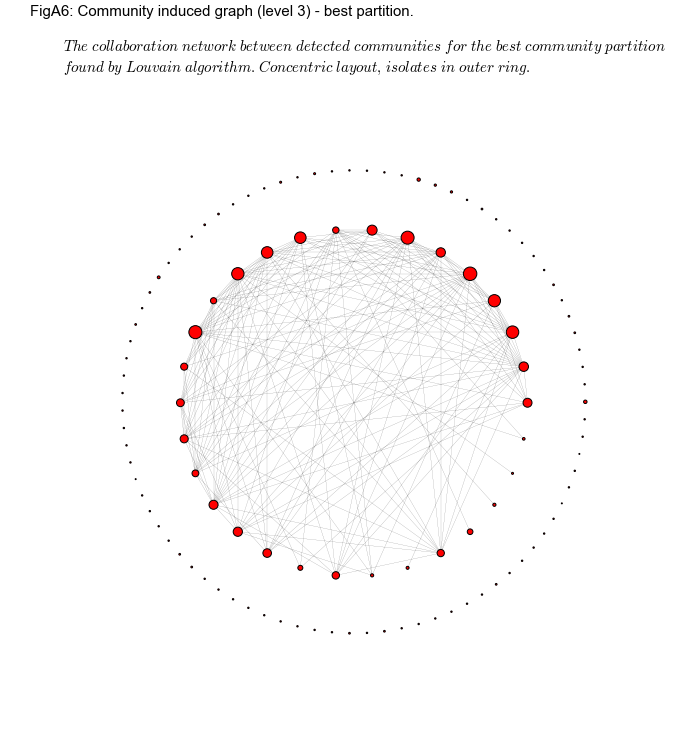

In [356]:
IG = community.induced_graph(graph=G, partition=part2)
community_sizes = _calc_group_sizes(part2)

plt.figure(figsize=(9,9))
test_nodes = IG.nodes()
isolates  = []
for node in test_nodes:
    node_in_edges = False
    for ed in IG.edges():
        if node in ed and ed[0]!=ed[1]:
            node_in_edges = True
            break
    
    if not node_in_edges:
        isolates.append(node)

connected = [node for node in IG.nodes() if node not in isolates]        
_sub0 = IG.subgraph(nbunch=isolates)
_sub1 = IG.subgraph(nbunch=connected)

pos0 = nx.circular_layout(_sub0)
nx.draw(_sub0, pos=pos0, nodelist=_sub0.nodes(), node_size=[community_sizes[n] for n in _sub0.nodes()])
#nx.draw_circular(_sub0, nodelist=_sub0.nodes(), node_size=[community_sizes[n] for n in _sub0.nodes()])
pos = nx.circular_layout(_sub1)
for p in pos.keys():
    pos[p][0] = pos[p][0]*0.75 + 0.125
    pos[p][1] = pos[p][1]*0.75 + 0.125
    
nx.draw(_sub1, pos=pos, nodelist=_sub1.nodes(), node_size=[community_sizes[n] for n in _sub1.nodes()], width=0.1)

tfs=15
subtitle = 'The collaboration network between detected communities for the best community partition'.replace(' ','\ ')
subtitle_l2 = 'found by Louvain algorithm. Concentric layout, isolates in outer ring.'.replace(' ','\ ')
title = plt.title('FigA6: Community induced graph (level 3) - best partition. \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')

Compare this **community induced graph** (FigA6) to the **organisation induced graph** (FigA2) that we looked at initially, plotted now with the same concentric layout: 

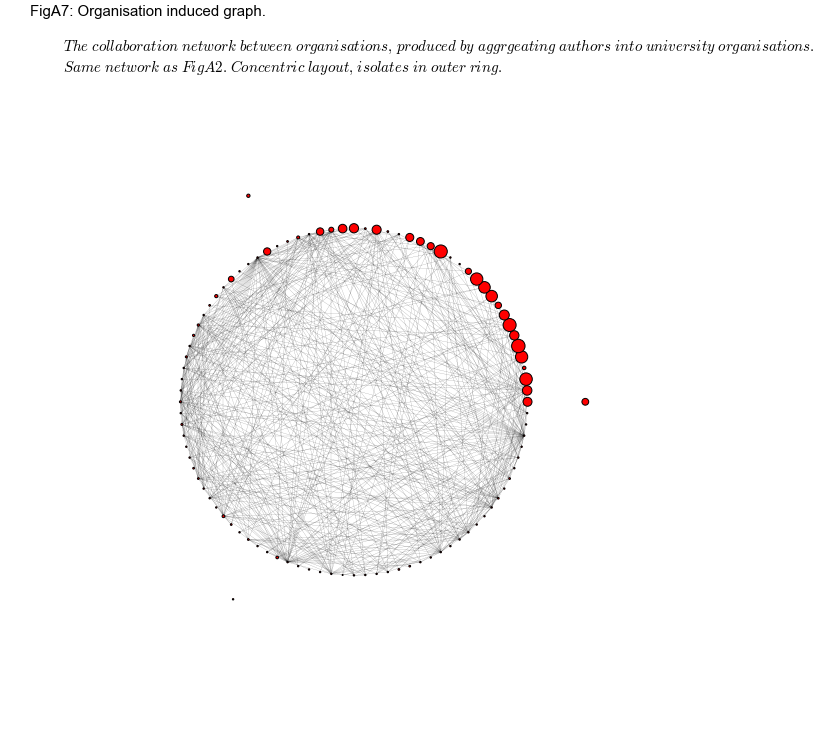

In [357]:
node_scaling = 1.2
partition_pure = dict(zip(staff['PERSON_ID'], staff['orgid']))
IG = community.induced_graph(graph=G, partition=partition_pure)
organisation_sizes = _calc_group_sizes(partition_pure)

plt.figure(figsize=(9,9))
test_nodes = IG.nodes()
isolates  = []
for node in test_nodes:
    node_in_edges = False
    for ed in IG.edges():
        if node in ed and ed[0]!=ed[1]:
            node_in_edges = True
            break
    
    if not node_in_edges:
        isolates.append(node)

_prev_sub0 = _sub0        
connected = [node for node in IG.nodes() if node not in isolates]        
_sub0 = IG.subgraph(nbunch=isolates)
_sub1 = IG.subgraph(nbunch=connected)

pos0 = pos0 ## use same circumferenc outer ring as previous plot - circular layout not working with only 3 isolates
pos0[20] = pos0[pos0.keys()[0]]
pos0[45] = pos0[pos0.keys()[28]]
pos0[47] = pos0[pos0.keys()[56]]
nx.draw(_sub0, pos=pos0, nodelist=_sub0.nodes(), node_size=[community_sizes[n] for n in _sub0.nodes()])
nx.draw_circular(_prev_sub0, nodelist=_prev_sub0.nodes(), node_size=0)
pos = nx.circular_layout(_sub1)
for p in pos.keys():
    pos[p][0] = pos[p][0]*0.75 + 0.125
    pos[p][1] = pos[p][1]*0.75 + 0.125
    
nx.draw(_sub1, pos=pos, nodelist=_sub1.nodes(), node_size=[community_sizes[n] for n in _sub1.nodes()], width=0.1)

tfs=15
subtitle = 'The collaboration network between organisations, produced by aggrgeating authors into university organisations.'.replace(' ','\ ')
subtitle_l2 = 'Same network as FigA2. Concentric layout, isolates in outer ring.'.replace(' ','\ ')
title = plt.title('FigA7: Organisation induced graph. \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')


* The community induced graph (FigA4) has 83 isolates, and 203 links.
* The organisation induced graph (FigA5) has 3 isolates, and 542 links.

This tells us that the amount of inter-group collaboration is much higher when using the conventional organisational structure.

It seems that the community partition goes some way towards capturing the *units of collaboration* within the university.

However, despite the best attempts of the Louvain algorithm, a lot of collaboration between communities remains. In fact the *connected component* (inner circle of FigA4) has a connectance of 0.47, meaning that almost half of all potential inter-community links are realised. 

#### It seems that it would be optimistic to try to divide authors into totally distinct *units of collaboration*.

However, the community strucutre determined from the collaboration network can tell us some interesting things...

* *Modularity* is a measure of the extent of intra-group interaction over inter-group interaction. It is equal to one if all interactions occur within groups (i.e. all nodes in the induced graph are isolates). We evaluate the modularity for each of the partitions considered so far, to quantify the extent of inter-group collaboration in each case.


* *Mutual information* (M.I.) is a similarity metric that captures the amount of  shared information (Shanon entropy) between two variables. We calculate the mutual information between each partition and the 'organisational' partition to determine their similarity. M.I. score (calculated with *scikit-learn*) is adjusted to account for different numbers of groups in a partition.

For comparison, we include a randomly assigned parition with the same number of groups as the best community partition (Louvain level 3: Fig4A).

In [283]:
partition_pure_authors_only = {author: org for author,org in zip(partition_pure.keys(),partition_pure.values()) if author in part0.keys()}
partition_summary = graphlab.SFrame()
partition_summary['Partition'] = ['University Organisations', 'Louvain Communities L1', 'Louvain Communities L2', 'Louvain Communities L3', 'Random Partition (||L3||)']

partition_list = [partition_pure_authors_only, part0, part1, part2, part_rand]
partition_summary['Modularity'] = ['%.4f' %community.modularity(graph=G, partition=part) for part in partition_list]

node_order = partition_pure_authors_only.keys()
mi = lambda part_a,part_b: sklm.mutual_info_score([part_a[node] for node in node_order], [part_b[node] for node in node_order])
ami = lambda part_a,part_b: sklm.adjusted_mutual_info_score([part_a[node] for node in node_order], [part_b[node] for node in node_order])
nmi = lambda part_a,part_b: sklm.normalized_mutual_info_score([part_a[node] for node in node_order], [part_b[node] for node in node_order])
#partition_summary['Normalised M.I.'] = ['%.4f' %nmi(partition_pure_authors_only, part) for part in partition_list]
#partition_summary['Mutual Information'] = ['%.4f' %mi(partition_pure_authors_only, part) for part in partition_list]
partition_summary['Adjusted M.I.'] = ['%.4f' %ami(partition_pure_authors_only, part) for part in partition_list]

partition_summary

Columns:
	Partition	str
	Modularity	str
	Adjusted M.I.	str

Rows: 5

Data:
+---------------------------+------------+---------------+
|         Partition         | Modularity | Adjusted M.I. |
+---------------------------+------------+---------------+
|  University Organisations |   0.5515   |     1.0000    |
|   Louvain Communities L1  |   0.6602   |     0.2820    |
|   Louvain Communities L2  |   0.7849   |     0.4155    |
|   Louvain Communities L3  |   0.7939   |     0.4334    |
| Random Partition (||L3||) |  -0.0002   |     0.0025    |
+---------------------------+------------+---------------+
[5 rows x 3 columns]

The modularity produced by the university's organistional structure is much higher than random, as we would expect.  The community partition (L3) drammatically improves on this, containing much more of the research collaboration within 'units'.

From the mutual information we see that there is some similarity between the best community partition (L3) and the organisational partition, and as we might expect. But it is how they differ that is interesting... 

Studying the communities themselves can tell us a lot about the interdisciplinary nature of the research they produce.

For example, we might want to know about the organisational groups that are working together within each community. 

In Ecology the *Shannon entropy* is often used to calculate the diversity of an ecosystem [2], based on the relative abundance of each species. Here we use this metric to determine the organisational diversity of each community, based on the relative abundance of each organisation it contains. For *N* organisations, the metric is maximal at *ln(N)* when all organisations in the community are present with equal abundance.     

In [68]:
def _shanon(community, staff):
    '''Calculates the Shanon (organisational) diversity of a given community.'''
    
    _community_staff = staff.filter_by(column_name='PERSON_ID', values=community)
    organisational_partition = dict(zip(_community_staff['PERSON_ID'], _community_staff['orgid']))
    org_sizes = _calc_group_sizes(organisational_partition)
    
    
    total = sum(org_sizes.values())
    diversity = [(size/float(total))*np.log(size/float(total)) for size in org_sizes.values()]
    
    return - sum(diversity)

In [69]:
community_diversity_best_partition = graphlab.SFrame()
community_diversity_best_partition['comid'] = np.unique(part2.values())
div_col = []
for com in community_diversity_best_partition['comid']:
    com = [key for key in part2 if part2[key]==com]
    div_col.append(_shanon(com, staff))
    
community_diversity_best_partition['diversity'] = div_col

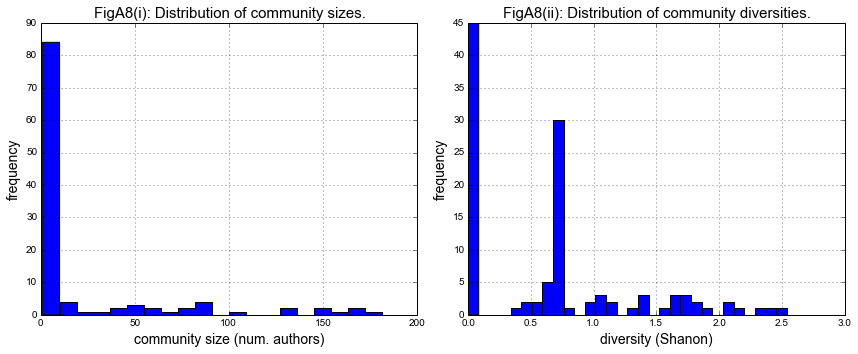

In [363]:
fsa =14
tfs=15
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(_calc_group_sizes(part2).values(), bins=20)
plt.xlabel('community size (num. authors)', fontsize=fsa)
plt.ylabel('frequency', fontsize=fsa)
plt.grid()
t1 = plt.title('FigA8(i): Distribution of community sizes.', fontsize=tfs)

plt.subplot(1,2,2)
plt.hist(community_diversity_best_partition['diversity'], bins=30)
plt.xlabel('diversity (Shanon)', fontsize=fsa)
plt.ylabel('frequency', fontsize=fsa)
plt.grid()
t2 = plt.title('FigA8(ii): Distribution of community diversities.', fontsize=tfs)
plt.tight_layout()

From the right hand plot we see that the distribution of diversities is bi-modal. It has a peak at zero, corresponding to communities that contain authors from a single organisation. It has a second peak in diversity close to 0.7 - it turns out that this corresponds to communities of two authors from different organisations (*ln(2)=0.693*). 

From this we learn that a significant amount of interdisciplinarity comes from pair-wise inter-organisational collaborations. Such pairings account for over a third in the peak of small commnuities seen in the left hand plot. 

#### We now consider the most diverse community - that with the highest Shanon entropy.

The organisational compostion of the community looks like this:

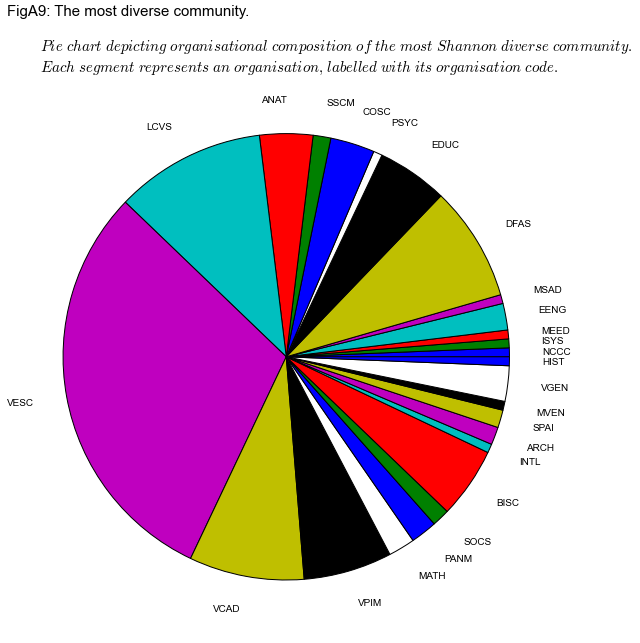

In [366]:
ordered = community_diversity_best_partition.sort('diversity', ascending=False)
top_com = ordered[0]['comid']

ids_in_com = [node for node in part2.keys() if part2[node]==top_com]
com = staff.filter_by(column_name='PERSON_ID', values=ids_in_com).groupby('orgid', operations={'count':agg.COUNT('PERSON_ID'), 'code':agg.SELECT_ONE('ORGANISATION_CODE')})
plt.figure(figsize=(10,10))
t=plt.pie(com['count'], labels=com['code'], labeldistance=1.15)

tfs=15
subtitle = 'Pie chart depicting organisational composition of the most Shannon diverse community.'.replace(' ','\ ')
subtitle_l2 = 'Each segment represents an organisation, labelled with its organisation code.'.replace(' ','\ ')
title = plt.title('FigA9: The most diverse community. \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')

Clearly there are a number of different organisations collaborating within this community.

The network of intra-community collaborations for the same community looks like this:

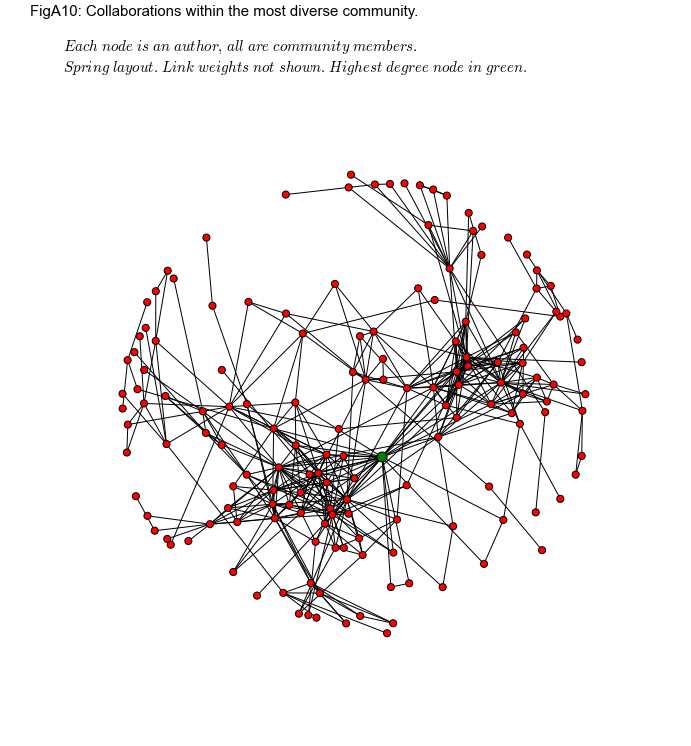

In [368]:
ordered = community_diversity_best_partition.sort('diversity', ascending=False)
top_com = ordered[0]['comid']

ids_in_com = [node for node in part2.keys() if part2[node]==top_com]
_sub = G.subgraph(nbunch=ids_in_com)
plt.figure(figsize=(9,9))
#nx.draw_circular(_sub, node_size=50)
pos = nx.spring_layout(_sub)
nx.draw(_sub, node_size=50, pos=pos)
hub = nx.draw_networkx_nodes(G=_sub, nodelist=[7520], node_color='green', pos=pos, node_size=100)

tfs=15
subtitle = 'Each node is an author, all are community members.'.replace(' ','\ ')
subtitle_l2 = 'Spring layout. Link weights not shown. Highest degree node in green.'.replace(' ','\ ')
title = plt.title('FigA10: Collaborations within the most diverse community. \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')

The above network plot uses a spring layout (as in FigA2).

It appears that there is some interesting collaboration structure within this community. For example, there are two highly connected sub-graphs. The highest degree author (plotted in green) appears to form a key bridge between these sub-graphs (although conclusions should not be made on network drawings alone!).

It would likely prove fruitful to further investigate the patterns within and between communities, both in terms of organisational and network structure.  

However, due to time limitations, we finish section A with the assumption that the comunities detected are reasonably coherent units of collaboration. Once again we plot the community induced graph (for the best Louvain partition), this time with:

* Communities coloured according to their diversity (blue=low; red=high Shanon organisational entropy).
* Community plotted size scaled according to number of authors in the community.
* Link width scaled according to weight (number of co-authored publications).
* The same concentric layout.

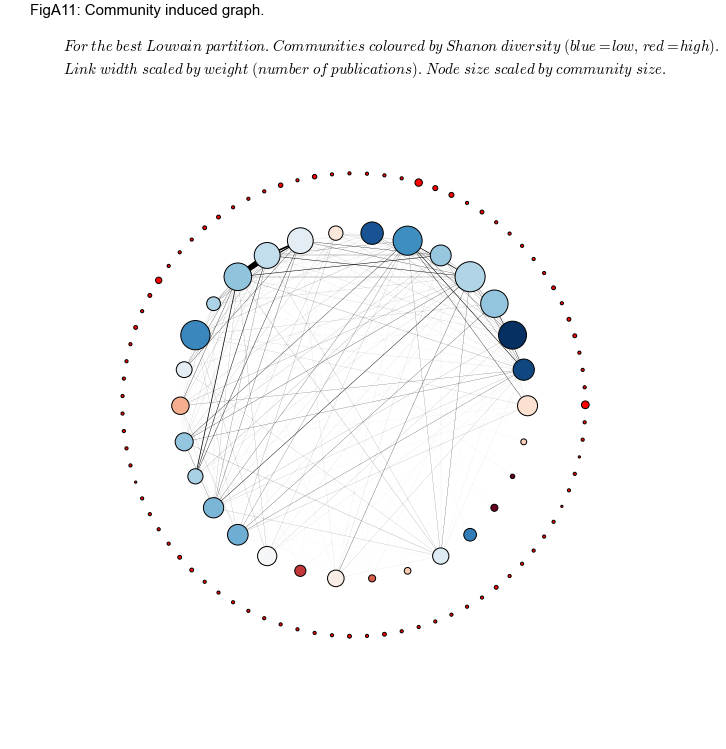

In [376]:
node_scaling = 5
edge_scaling = 0.01
IG = community.induced_graph(graph=G, partition=part2)

plt.figure(figsize=(9,9))
cmap = 'RdBu'

test_nodes = IG.nodes()
isolates  = []
for node in test_nodes:
    node_in_edges = False
    for ed in IG.edges():
        if node in ed and ed[0]!=ed[1]:
            node_in_edges = True
            break
    
    if not node_in_edges:
        isolates.append(node)

connected = [node for node in IG.nodes() if node not in isolates]        
_sub0 = IG.subgraph(nbunch=isolates)
_sub1 = IG.subgraph(nbunch=connected)

nx.draw_circular(_sub0, nodelist=_sub0.nodes(), node_size=[node_scaling * community_sizes[n] for n in _sub0.nodes()])

pos = nx.circular_layout(_sub1)
for p in pos.keys():
    pos[p][0] = pos[p][0]*0.75 + 0.125
    pos[p][1] = pos[p][1]*0.75 + 0.125

diversity_dict = dict(zip(community_diversity_best_partition['comid'], community_diversity_best_partition['diversity']))
_temp = nx.draw_networkx_nodes(_sub1, pos=pos, nodelist=_sub1.nodes(), node_size=[node_scaling * community_sizes[n] for n in _sub1.nodes()], node_color=[diversity_dict[n] for n in _sub1.nodes()], cmap=cmap, width=0.5)
_temp = nx.draw_networkx_edges(_sub1, pos=pos, edgelist=[edge for edge in _sub1.edges()], width=[edge_scaling * _sub1.get_edge_data(edge[0], edge[1])['weight'] for edge in _sub1.edges()])

tfs=15
subtitle = 'For the best Louvain partition. Communities coloured by Shanon diversity (blue=low, red=high).'.replace(' ','\ ')
subtitle_l2 = 'Link width scaled by weight (number of publications). Node size scaled by community size.'.replace(' ','\ ')
title = plt.title('FigA11: Community induced graph. \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')

## B. The publication network

The premise of the previous section was that we could find coherent units of collaboration by grouping auhtors into communities, based on the structure of the collaboration network. This approach yielded some initial insights that it would have been nice to spend more time exploring. But we must move on..

In this section we take the *inverse of the collaboration network* - now each node is a publication, and two nodes are connected if they share at least one author. We call this the *publication network*. 

As with the collaboration network, we remove isolates (i.e. publications that share no author with any other).

(Currently this network is unweighted, but link weights could be given by the number of authors shared by two papers.)

With almost 30,000 nodes, and over 900,000 edges, the publication network is too large to meaningfully plot. But, similar to our approach in section A, we can use community detection to aggregate the publications into groups based on the authorship structure.  

The premise here is that these communities of publications represent distinct **fields of knowledge** - and that again, these fields may differ somehow from those encoded in the organisational structure of the university.

In [386]:
## We generate the edge list in a separate script (pub_net_script2.py)
f = open('./publication_net_links_dict.pkl', 'rb')
_pub_links = pickle.load(f)
f.close()

In [382]:
PG = nx.Graph()

for pub in authors['PUBLICATION_ID'].unique():
    PG.add_node(pub)

for link in _pub_links:
    PG.add_edge(u=link[0], v=link[1])
    

degrees = PG.degree()
for node in PG.nodes():
    if degrees[node]==0:
        PG.remove_node(node)

In [419]:
part_pub = community.best_partition(PG)
IG_PG = community.induced_graph(graph=PG, partition=part_pub)

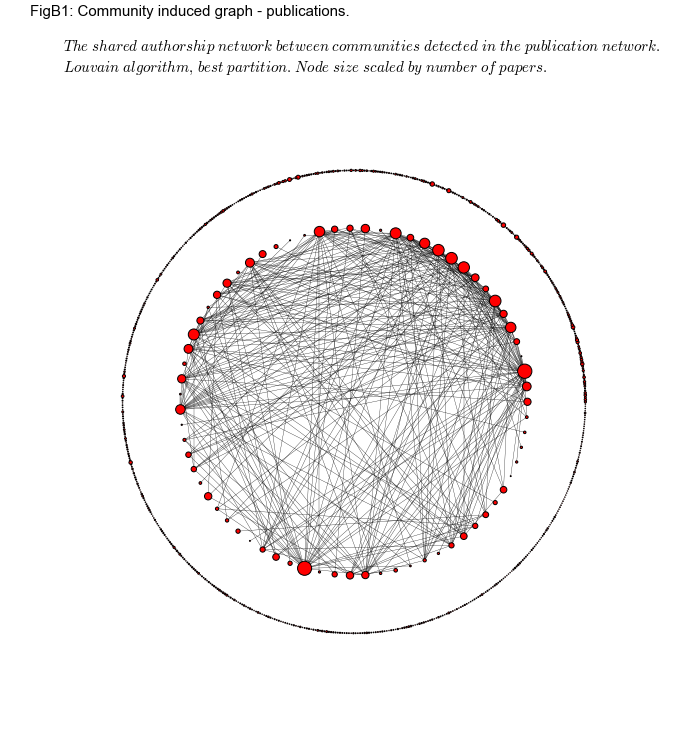

In [457]:
IG = IG_PG
community_sizes = _calc_group_sizes(part_pub)

node_scaling = 0.15
plt.figure(figsize=(9,9))
test_nodes = IG.nodes()
isolates  = []
for node in test_nodes:
    node_in_edges = False
    for ed in IG.edges():
        if node in ed and ed[0]!=ed[1]:
            node_in_edges = True
            break
    
    if not node_in_edges:
        isolates.append(node)

connected = [node for node in IG.nodes() if node not in isolates]        
_sub0 = IG.subgraph(nbunch=isolates)
_sub1 = IG.subgraph(nbunch=connected)

pos0 = nx.circular_layout(_sub0)
nx.draw(_sub0, pos=pos0, nodelist=_sub0.nodes(), node_size=[node_scaling * community_sizes[n] for n in _sub0.nodes()])
#nx.draw_circular(_sub0, nodelist=_sub0.nodes(), node_size=[community_sizes[n] for n in _sub0.nodes()])
pos = nx.circular_layout(_sub1)
for p in pos.keys():
    pos[p][0] = pos[p][0]*0.75 + 0.125
    pos[p][1] = pos[p][1]*0.75 + 0.125
    
nx.draw(_sub1, pos=pos, nodelist=_sub1.nodes(), node_size=[node_scaling * community_sizes[n] for n in _sub1.nodes()], width=0.3)

tfs=15
subtitle = 'The shared authorship network between communities detected in the publication network.'.replace(' ','\ ')
subtitle_l2 = 'Louvain algorithm, best partition. Node size scaled by number of papers.'.replace(' ','\ ')
title = plt.title('FigB1: Community induced graph - publications. \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')

This network is qualitatively similar to the community induced graph from section a (FigA6).

We observe a large number of small isolated communities, and a core of larger interacting communities. 

Here the isolates represent small collections of publications that share no author with any other community in the network.

The larger communities in the core should have many intra-community shared authorship links, but also retain links to other communities. These inter-community links may be of interest - representing authors that bridge fields of knowledge.  

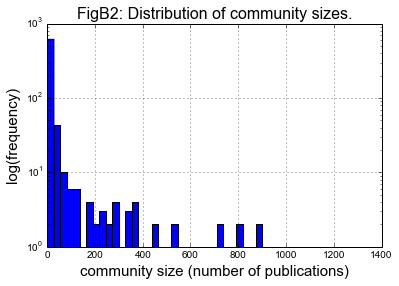

In [428]:
fsa = 15
tfs = 16
hist = plt.hist(community_sizes.values(), bins=50)
plt.yscale('log', nonposy='clip')
plt.xlabel('community size (number of publications)', fontsize=fsa)
plt.ylabel('log(frequency)', fontsize=fsa)
plt.grid()
tit = plt.title('FigB2: Distribution of community sizes.', fontsize=tfs)

Community sizes display a long-tailed distribution, with many small communities and few larger ones. Note that the y-axis scale in FigB2 is logarithmic.

Many of these smaller communities are isolates (651 isolates in total), and therefore represent distinct fields of knowledge based on authorship.

But to what extent can the larger communities be considered distinct fields of knowledge?

We now plot network structure of the largest community:

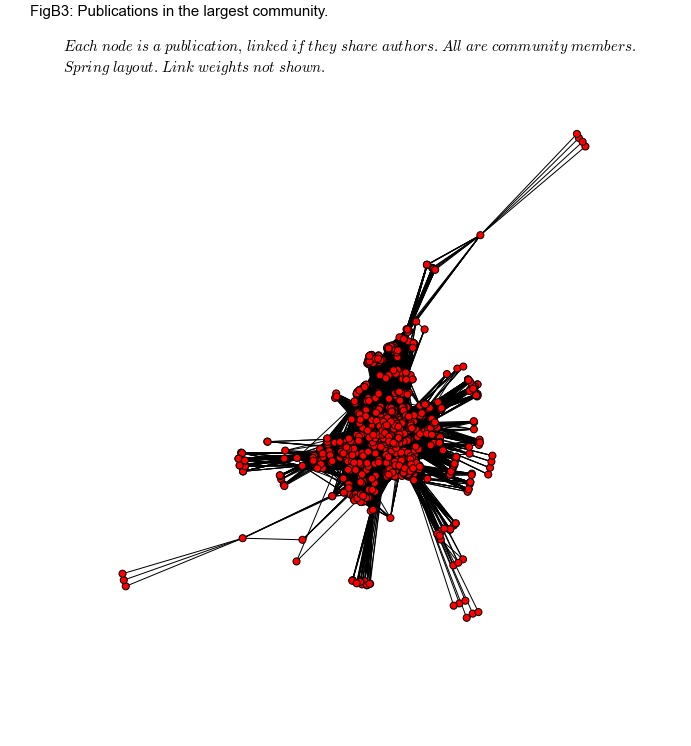

In [467]:
top_com = 3

ids_in_com = [node for node in part_pub.keys() if part_pub[node]==top_com]
_sub = PG.subgraph(nbunch=ids_in_com)
plt.figure(figsize=(9,9))
pos = nx.spring_layout(_sub)
nx.draw(_sub, node_size=50, pos=pos)

tfs=15
subtitle = 'Each node is a publication, linked if they share authors. All are community members.'.replace(' ','\ ')
subtitle_l2 = 'Spring layout. Link weights not shown.'.replace(' ','\ ')
title = plt.title('FigB3: Publications in the largest community. \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')

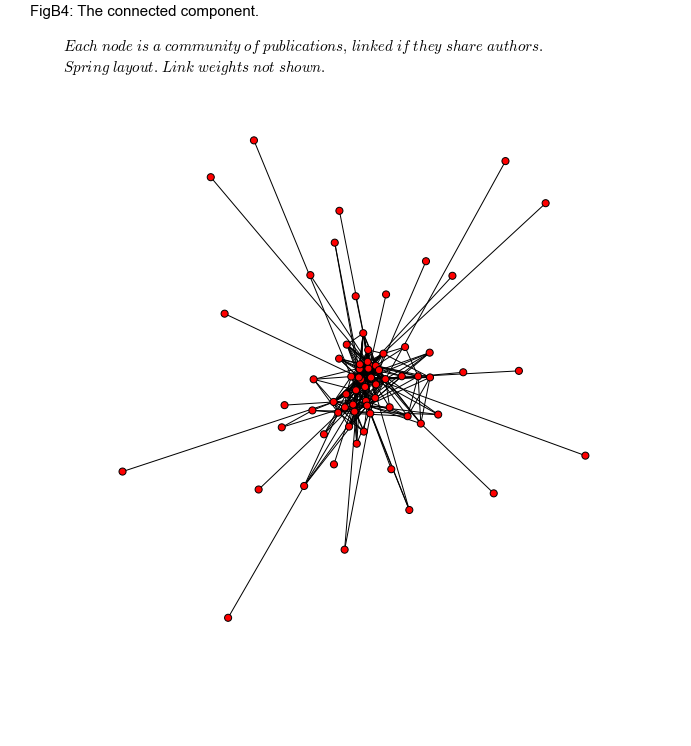

In [468]:
plt.figure(figsize=(9,9))

pos = nx.spring_layout(_sub1)
nx.draw(_sub1, node_size=50, pos=pos)

tfs=15
subtitle = 'Each node is a community of publications, linked if they share authors.'.replace(' ','\ ')
subtitle_l2 = 'Spring layout. Link weights not shown.'.replace(' ','\ ')
title = plt.title('FigB4: The connected component. \n\n\t$%s$\n\t$%s$' %(subtitle,subtitle_l2), fontsize=tfs, loc='left')

There seems to be some interesting structure here, in the shared authorships of these publications. It may well be informative to explore the structures for the larger communities (inner ring of FigB1), but such exploration is beyond the scope of this work. 

It would also be interesting to look at the similarity of pubilications within these communities - do they come from the same or similar journals? Do they share keywords? 

**If these communities did prove themselves to be distinct fields or knowledge, could we then identify truly interdisciplinary authors as those which link these distinct fields?**

Any such conclusions based on the current analysis would be premature, and are highly sensitive to the partitions used. Therefore we refrain from drawing conclusions in the absence of more rigour. 

## C. The bipartite network

We now look to a novel representation of interdisciplinarity, that extends on the approach developed in sections A and B. 

So far we have used community detection to try and detect: (1) distinct units of collaboration (groups of authors), and (2) distinct fields of knowledge (groups of papers).

We now combine these groupings by constructing a *bipartite* network - that is, a network with two different types of node. Each node can only interact with those of the other type.

In community ecology bipartite networks are used, among other things, to encode information about *mutualistic systems*.  

For example, a *flower-visitation* or *pollination* network encodes information about pollination. Pollination is a mutualistic interaction, since both parties benefit. Therefore the network is said to be mutualistic.  

Here's a simple example from [3]:

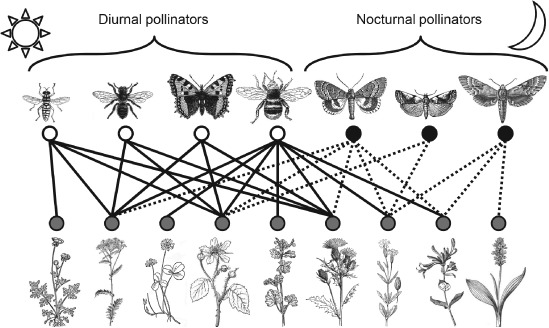

In [463]:
im = Image('./mut_net_example.jpeg')
sh = display(im)

The main assumptions here are that:

* The animals and plants are grouped into coherent species.
* Each pollinator species only interacts with certain plants.
* Something meaningful can be learned from studying the network structure formed by these interactions. 

We now make the imaginative leap that...

The publications are grouped into the commnuities depicted in FigB1.

For authors we have two choices.

Grouping the authors into the university organisations (as in FigA7), the bipartite network looks like this:

In [450]:
author_partition = graphlab.SFrame()
author_partition['PERSON_ID'] = part2.keys()
author_partition['COM'] = [part2[pid] for pid in author_partition['PERSON_ID']]

In [451]:
pub_partition = graphlab.SFrame()
pub_partition['PUBLICATION_ID'] = part_pub.keys()
pub_partition['PCOM'] = [part_pub[pid] for pid in pub_partition['PUBLICATION_ID']]

In [452]:
community_interacions = authors.join(pub_partition, on='PUBLICATION_ID', how='inner')
community_interacions = community_interacions.join(author_partition, on='PERSON_ID', how='inner')
community_interacions = community_interacions.join(staff, on='PERSON_ID', how='inner')

In [453]:
r_edges_coms = community_interacions.groupby(['PCOM','COM'],operations={'FREQ':agg.COUNT('PUBLICATION_ID')})
r_edges_coms.save('r_edges_coms.csv')
r_edges_orgs = community_interacions.groupby(['PCOM','orgid'],operations={'FREQ':agg.COUNT('PUBLICATION_ID')})
r_edges_orgs.save('r_edges_orgs.csv')

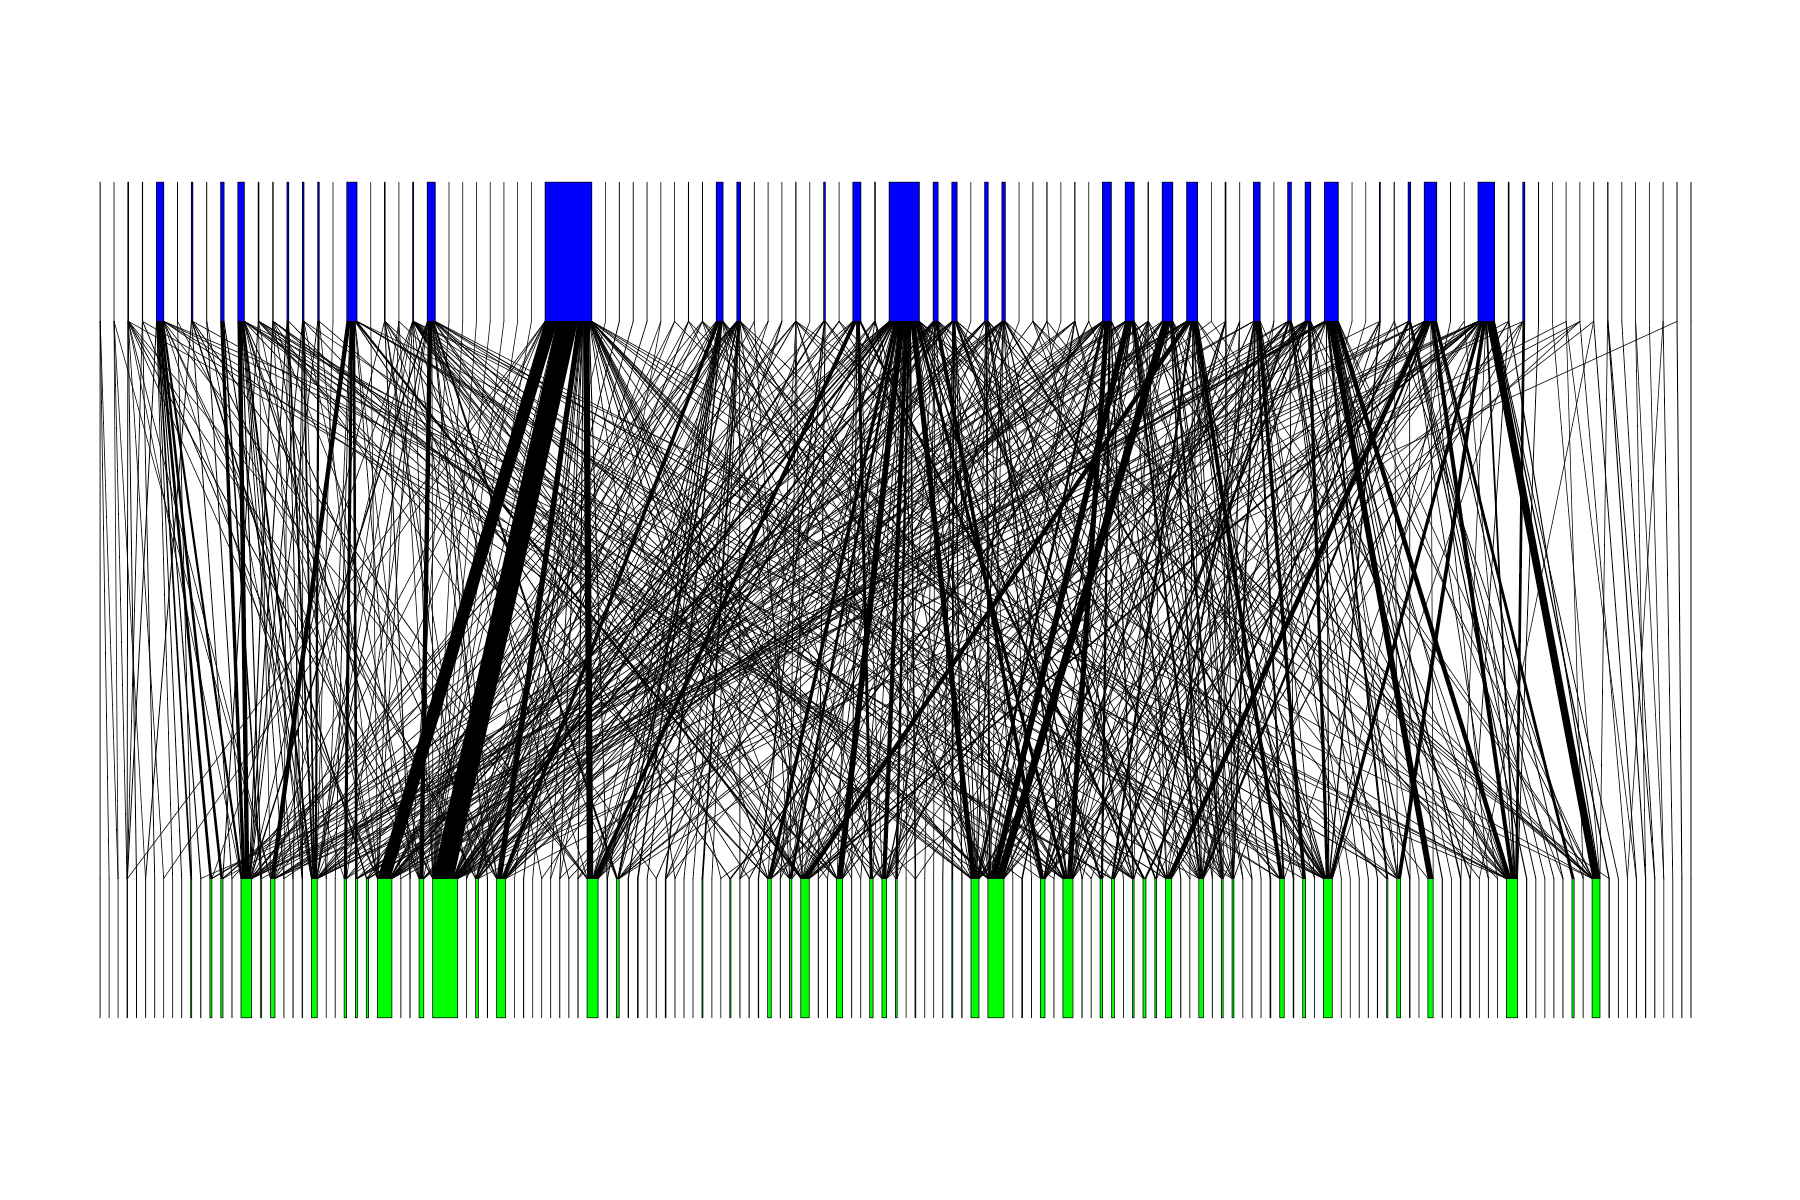

In [469]:
## plotting is done in R using package 'bipartite'
im=Image('./bipartite_organisations.png')
display(im)

And grouping the authors based on the best Louvain communities (as shown in FIG**X**):

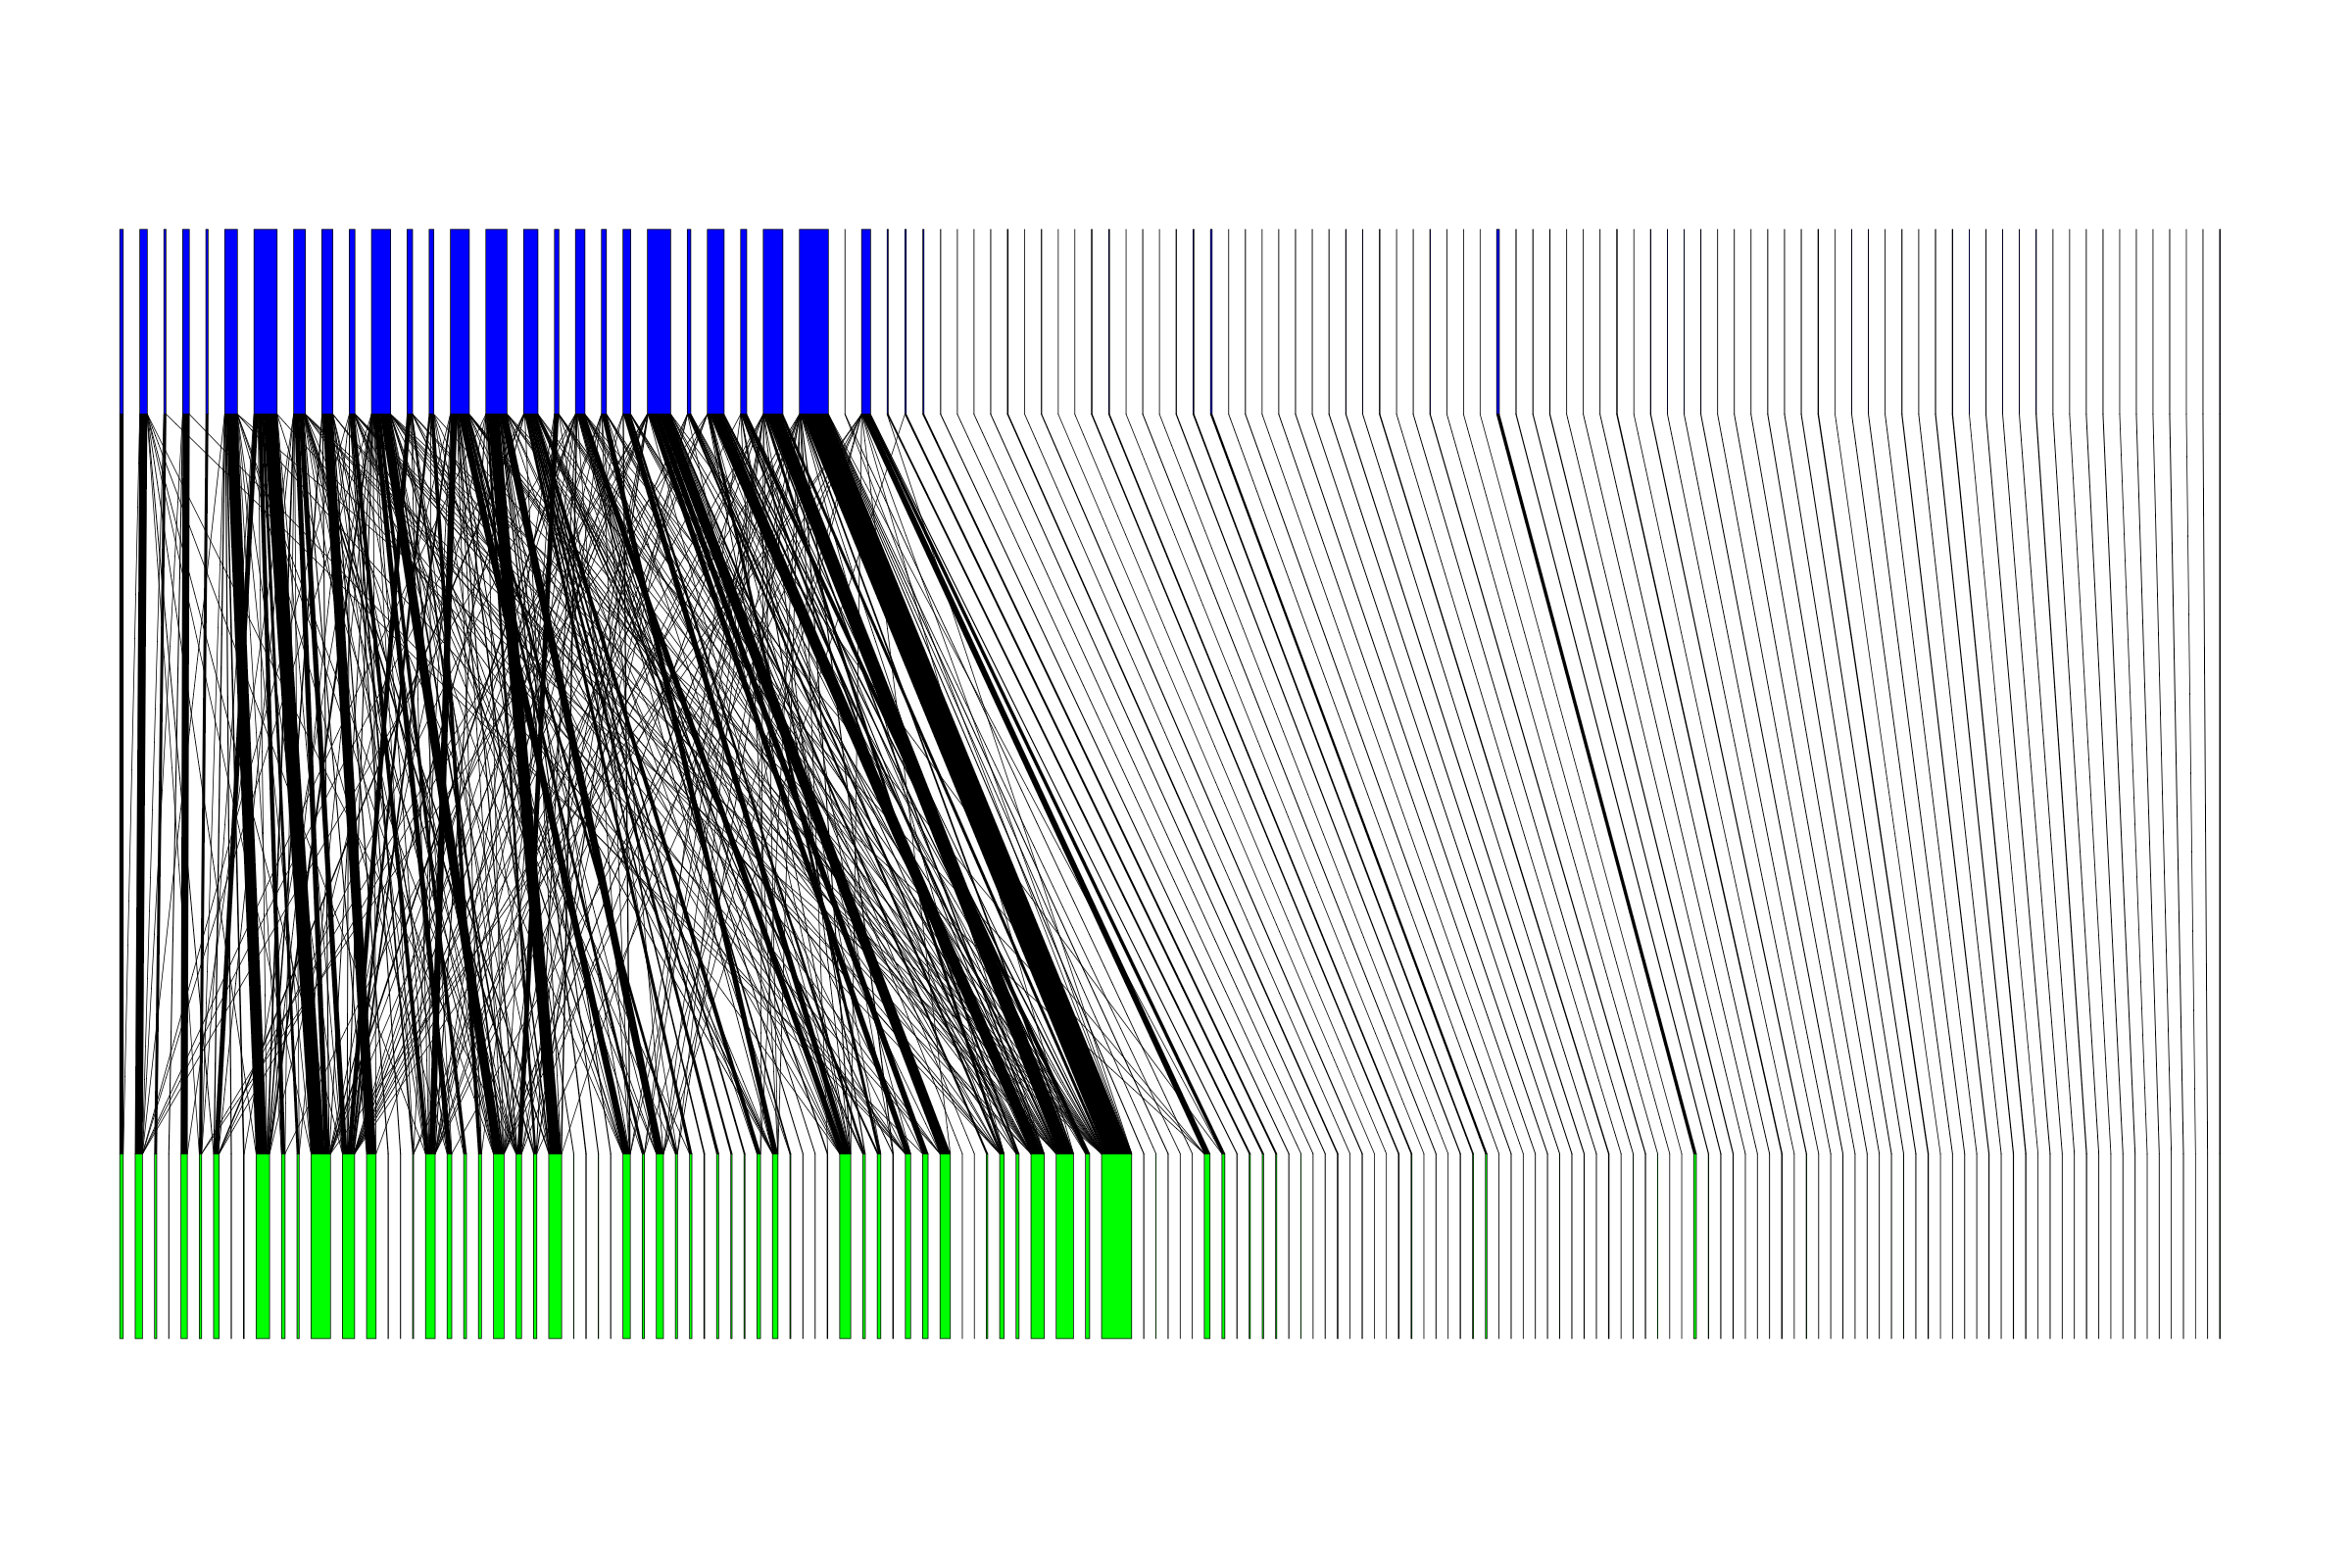

In [471]:
## plotting is done in R using package 'bipartite'
im=Image('./bipartite_communities.png')
display(im)

In [126]:
r_edges_p9742 = community_interacions[community_interacions['PERSON_ID']==11155].groupby(['PCOM','orgid'],operations={'FREQ':agg.COUNT('PUBLICATION_ID')})
r_edges_p9742_matrix = graphlab.SFrame()
r_edges_p9742_matrix['PCOM'] = r_edges_p9742['PCOM']
r_edges_p9742_matrix['p11155'] = [freq for freq in r_edges_p9742['FREQ']]
r_edges_p9742_matrix.save('./r_edges_p11155.csv')

In [124]:
r_edges_p9742 = community_interacions[community_interacions['PERSON_ID']==9742].groupby(['PCOM','orgid'],operations={'FREQ':agg.COUNT('PUBLICATION_ID')})
r_edges_p9742_matrix = graphlab.SFrame()
r_edges_p9742_matrix['PCOM'] = r_edges_p9742['PCOM']
r_edges_p9742_matrix['p9742'] = [freq for freq in r_edges_p9742['FREQ']]
r_edges_p9742_matrix.save('./r_edges_p9742.csv')

In [136]:
r_edges = community_interacions.filter_by(column_name='PERSON_ID',values=[11155,9742]).groupby(['PCOM','orgid'],operations={'FREQ':agg.COUNT('PUBLICATION_ID')})
r_edges_matrix = graphlab.SFrame()
r_edges_matrix['PCOM'] = r_edges['PCOM']
r_edges_matrix['p9742'] = [row['FREQ'] if row['orgid']==55 else 0 for row in r_edges]
r_edges_matrix['p11155'] = [row['FREQ'] if row['orgid']==35 else 0 for row in r_edges]
r_edges_matrix.save('./r_edges_two.csv')

In [138]:
community_interacions.groupby(['PERSON_ID', 'PCOM'], operations={'cnt':agg.COUNT_DISTINCT('PUBLICATION_ID')})
#r_edges
#community_interacions.groupby('PERSON_ID', operations={'cnt':agg.COUNT_DISTINCT('PCOM')}).sort('cnt', ascending=False)

Columns:
	PCOM	int
	PERSON_ID	int
	cnt	int

Rows: 3482

Data:
+------+-----------+-----+
| PCOM | PERSON_ID | cnt |
+------+-----------+-----+
|  6   |   23882   |  1  |
| 342  |    1170   |  6  |
|  10  |    8441   |  1  |
|  22  |   34763   |  6  |
|  11  |   47082   |  1  |
|  26  |   19739   |  1  |
| 104  |   28546   |  2  |
|  7   |   27832   |  1  |
|  2   |   21770   |  21 |
| 104  |   26027   |  5  |
+------+-----------+-----+
[3482 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [141]:
test=[8,0,0,0]
test2=[1,0,0,0]
sklm.jaccard_similarity_score(test,test2)

0.75

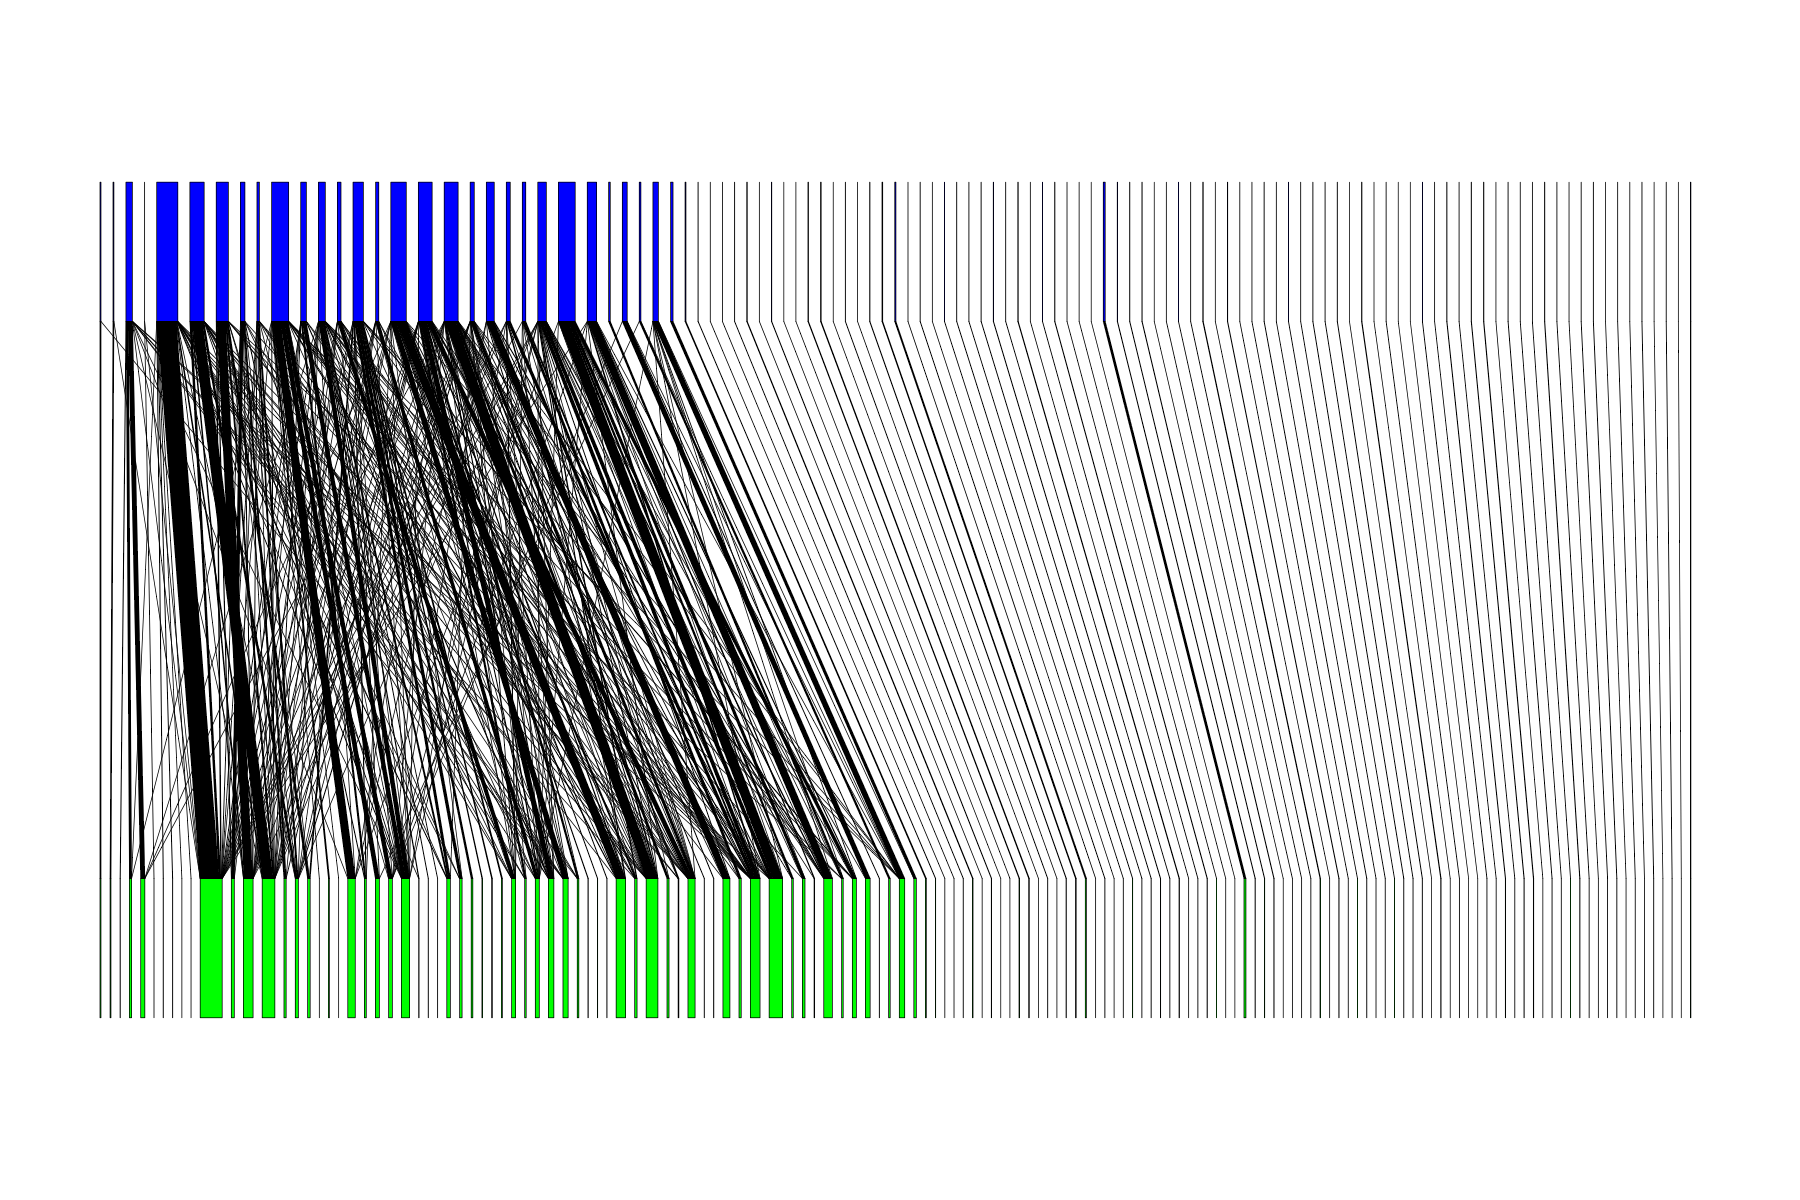

In [112]:
im=Image('./bipartite_communities.png')
display(im)

For these two networks we can compare the:

* connectance
* number of compartments
* nestedness?